In [1]:
# Packages
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
def simulate_garch(T, omega):
    np.random.seed(111)  # For reproducibility
    r = np.zeros(T)
    h = np.zeros(T)
    h[0] = omega[0] / (1 - omega[1] - omega[2])
    r[0] = np.random.normal(0, np.sqrt(abs(h[0]))) # abs

    
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        r[t] = np.random.normal(0, np.sqrt(abs(h[t]))) #abs
        
    return r, h

In [3]:
def log_likelihood(r, omega):
    T = len(r)
    h = np.zeros(T)
    h[0] = omega[0] / (1 - omega[1] - omega[2]) if (omega[1] + omega[2]) < 1 else 100000  # large number for stability
    
    log_lik = 0
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        log_lik -= 0.5 * (np.log(abs(h[t])) + r[t]**2 / h[t]) # abs
    
    return log_lik

def log_posterior(r, omega, sigma):
    log_prior = -0.5 * (omega[0]**2 / sigma[0]**2 + omega[1]**2 / sigma[1]**2 + omega[2]**2 / sigma[2]**2)
    return log_likelihood(r, omega) + log_prior

def log_post(omega):
    return log_posterior(returns, omega, sigma_omega)

def proposal(omega_old, sigma_proposal ): # function used in the MH algorithm that will "propose" the new parameter (new omega here)
    # omega_old is the list containing the old omegas, we will use a normal probability distribution to determine the new ones
    omega = np.array([0.0,0.0,0.0])
    omega[0] = np.random.normal(loc= omega_old[0], scale = sigma_proposal)
    omega[1] = np.random.normal(loc= omega_old[1], scale = sigma_proposal)
    omega[2] = np.random.normal(loc= omega_old[2], scale = sigma_proposal)

    return omega

def metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega):
    # Let's initialize our variable
    acceptation = np.array([False]*iterations) # we will through the iterations accept or not the change of value of omega
    omega = initial_omega
    omega_sampling = [omega]
    # Let's apply the algorithm trough all the iterations
    for t in range(iterations):
        # We propose a candidate for omegas
        omega_new = proposal(omega, sigma_proposal)
        # We calculate the acceptance alpha which is ratio of the prior of the new omega over the old omega
        alpha = log_posterior(returns,omega_new,sigma_omega) - log_posterior(returns,omega,sigma_omega)
        # We compare alpha with 1 and an uniform random number
        u = np.random.uniform(0,1)
        if alpha > 0:  # reminder that alpha is a log here so we don't compare with 1 but with 0
            acceptation[t] = True
            omega = omega_new
        if alpha < 0:
            if alpha > np.log(u): # we compare to log u and not u
                acceptation[t]= False
                omega = omega_new # we take the new omega
        omega_sampling.append(omega)
    acceptance_rate = np.sum(acceptation)/len(acceptation)*100
    return acceptance_rate, omega_sampling

def compute_h_t_derivatives(r, omega):
    T = len(r)
    h = np.zeros(T)
    grad_h_omega1 = np.zeros(T)
    grad_h_omega2 = np.zeros(T)
    grad_h_omega3 = np.zeros(T)

    # Initial volatility
    h[0] = omega[0]  

    # Compute h and its derivatives
    for t in range(1, T):
        h[t] = omega[0] + omega[1] * r[t-1]**2 + omega[2] * h[t-1]
        
        # Derivative of h_t with respect to omega[0]
        grad_h_omega1[t] = (1 - omega[2]**(t)) / (1 - omega[2]) if omega[2] != 1 else t  # Using the geometric series

        # Derivative of h_t with respect to omega[1]
        grad_h_omega2[t] = r[t-1]**2 + omega[2] * grad_h_omega2[t-1]

        # Derivative of h_t with respect to omega[2]
        grad_h_omega3[t] = h[t-1] + omega[2] * grad_h_omega3[t-1]

    return h, grad_h_omega1, grad_h_omega2, grad_h_omega3

def gradient(f, x):
    
    """
    It computes the gradient of function f at a point x.
    f is a function with many variables.
    x is the vector that that represents the point where the gradient is computed. 
    """
    h = 1e-6
    gradient = np.zeros_like(x)
    for i in range(x.size):
        x_plus_h = x.copy()
        x_plus_h[i] += h
        gradient[i] = (f(x_plus_h) - f(x)) / h
    return gradient

def control_variates(r, sigma, omega_samples):

    # We compute the log posterior gradients at every point
    log_post_gradient = compute_log_posterior_gradients(r, sigma, omega_samples)

    # We compute the control variates (z_i)
    z1 = -0.5*[ex[0] if isinstance(ex, np.ndarray) else ex[0] for ex in log_post_gradient]
    z2 = -0.5*[ex[1] if isinstance(ex, np.ndarray) else ex[1] for ex in log_post_gradient]
    z3 = -0.5*[ex[2] if isinstance(ex, np.ndarray) else ex[2] for ex in log_post_gradient]

    # We store these 3 control variates in an array 
    z = np.column_stack((z1, z2, z3))

    return z

In [4]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = [0.1, 0.2, 0.7], T = 1000)[0]

iterations = 5000
burn_in = 1000

std_prior = 10
std_proposal = 0.01

In [5]:
def extract_parameter_chains(liste):
    w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[1]]
    w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[1]]
    w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[1]]
    return np.column_stack((w1, w2, w3))

def compute_control_variates(w):
    gradients = [gradient(log_post, np.asarray(omega)) for omega in w]
    z1 = [0.5 * elem[0] for elem in gradients]
    z2 = [0.5 * elem[1] for elem in gradients]
    z3 = [0.5 * elem[2] for elem in gradients]
    return np.column_stack((z1, z2, z3))

def fit_linear_regression(Y, Z):
    regression = LinearRegression()
    regression.fit(Z, Y)
    return regression.coef_

def post_process_samples(w_samples, z_samples, burn_in, coefficients):
    w_after_burn_in = w_samples[burn_in:]
    z_after_burn_in = z_samples[burn_in:]
    aTz = np.dot(coefficients, (-z_after_burn_in).T).T
    return w_after_burn_in, aTz

def sum_list(liste1, liste2):
    result = []
    for i in range(len(liste1)):
        somme = liste1[i] + liste2[i]
        result.append(somme)
    return result

In [6]:
def w_tilde(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in):
    # Run Metropolis sampler
    samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)
    
    # Extract parameter chains
    w_samples = extract_parameter_chains(samples)
    
    # Compute control variates
    z_samples = compute_control_variates(w_samples)
    #z_samples = control_variates(returns, sigma_omega, w_samples)
    
    # Linear regression
    coefficients = fit_linear_regression(w_samples[burn_in:], z_samples[burn_in:])
    
    # Post-processing
    w_after_burn_in, transformed_samples = post_process_samples(w_samples, z_samples, burn_in, coefficients)

    # Print coefficients
    print("Coefficients of a from the regression of w on the control variates: ", coefficients)

    return w_after_burn_in, transformed_samples


In [7]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]
true_omega = [0.1, 0.1, 0.8]  # These are the true parameters we want to estimate
sigma_omega = [9,9,9]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = true_omega, T = 1000)[0]

iterations = 5000
burn_in = 1000

sigma_proposal = 0.01

w_tilde=w_tilde(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in)

In [ ]:
def w1_results(w):
    w1 = w_tilde[0][0:]
    transw1 = w_tilde[1][0:]
    w1_tilde = [x + y for x, y in zip(w1, transw1)]
    return np.mean(w1), np.mean(w1_tilde), np.var(w1), np.var(w1_tilde), w1_tilde

print("Expected value of w1 =", w1_results(w_tilde)[0])
print("Expected value of w1_tilde =", w1_results(w_tilde)[1])
print("Variance of w1 =", w1_results(w_tilde)[2])
print("Variance of w1_tilde =", w1_results(w_tilde)[3]) 

Expected value of w1 = 0.33360500230024787
Expected value of w1_tilde = 0.33367345359485834
Variance of w1 = 0.11956859551517314
Variance of w1_tilde = 0.11464282931859016


In [ ]:
def w2_results(w):
    w2 = w[0][1:]
    transw2 = w[1][1:]
    w2_tilde = [x + y for x, y in zip(w2, transw2)]
    return np.mean(w2), np.mean(w2_tilde), np.var(w2), np.var(w2_tilde), w2_tilde

mean_w2, mean_w2_tilde, var_w2, var_w2_tilde, _ = w2_results(w_tilde)

# Print results
print(f"Expected value of w2 = {mean_w2}")
print(f"Expected value of w2_tilde = {mean_w2_tilde}")
print(f"Variance of w2 = {var_w2}")
print(f"Variance of w2_tilde = {var_w2_tilde}")

Expected value of w2 = 0.33360439767368105
Expected value of w2_tilde = 0.33367353789047816
Variance of w2 = 0.11956605857240978
Variance of w2_tilde = 0.1146404999502988


In [ ]:
def w3_results(w):
    w3 = w[0][2:]
    transw3 = w[1][2:]
    w3_tilde = [x + y for x, y in zip(w3, transw3)]
    return np.mean(w3), np.mean(w3_tilde), np.var(w3), np.var(w3_tilde), w3_tilde

mean_w3, mean_w3_tilde, var_w3, var_w3_tilde, _ = w3_results(w_tilde)

# Print results
print(f"Expected value of w3 = {mean_w3}")
print(f"Expected value of w3_tilde = {mean_w3_tilde}")
print(f"Variance of w3 = {var_w3}")
print(f"Variance of w3_tilde = {var_w3_tilde}")

Expected value of w3 = 0.3336033754982119
Expected value of w3_tilde = 0.3336735794508466
Variance of w3 = 0.11956360918864327
Variance of w3_tilde = 0.11464104367199136


In [ ]:
def plot_comparison(w, w_tilde, name):
    plt.figure(figsize=(10, 4))
    plt.plot(w, label=f'MCMC {name}')
    plt.plot(w_tilde, label=f'ZV MCMC {name}')
    plt.legend(fontsize=20)
    plt.xlabel('Itérations après burn-in', fontsize=20)
    plt.title(f'Comparaison de la chaîne de Markov pour {name} entre MCMC et ZV MCMC', fontsize=20)
    plt.ylabel('Valeurs de omega', fontsize=20)
    plt.show()


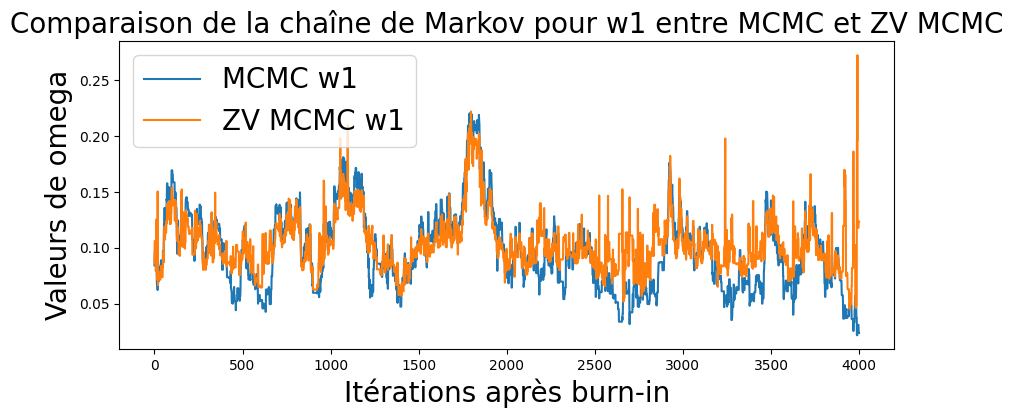

In [ ]:
#w_tilde[0] correspond en réalité à w1 de la Q1
plot_comparison(w_tilde[0][:, 0], [sub_array[0] for sub_array in w1_results(w_tilde)[4]], 'w1')


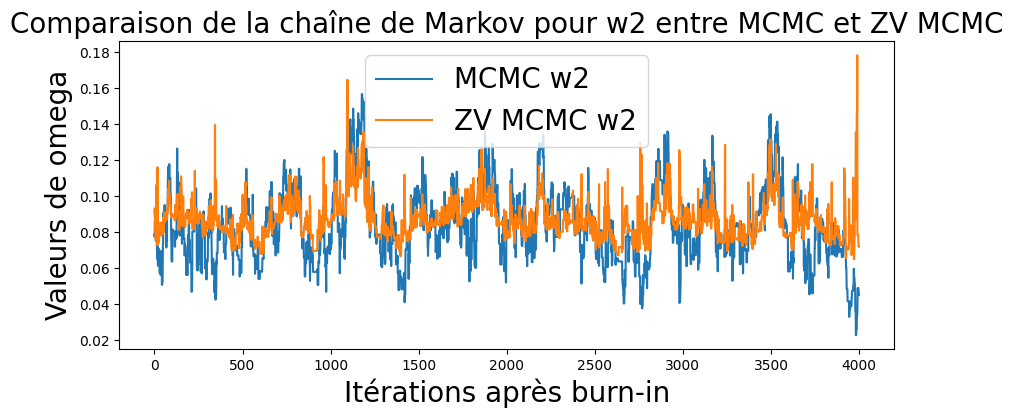

In [ ]:
plot_comparison(w_tilde[0][:, 1], [sub_array[1] for sub_array in w2_results(w_tilde)[4]], 'w2')

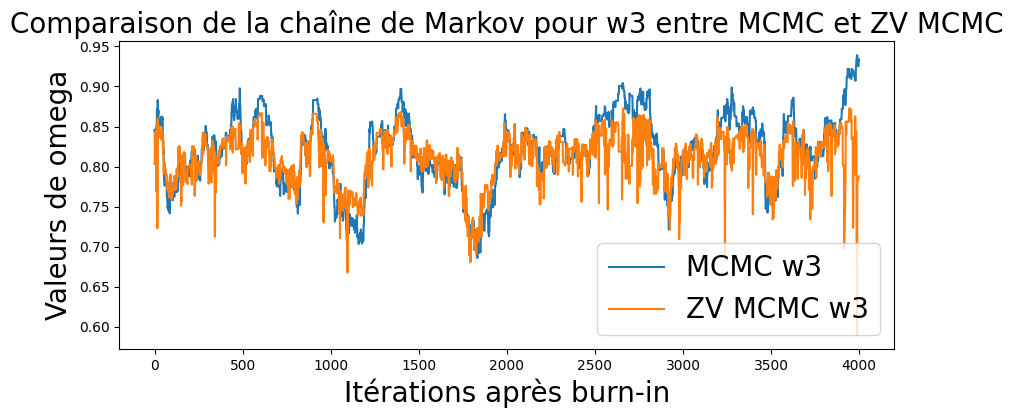

In [ ]:
plot_comparison(w_tilde[0][:, 2], [sub_array[2] for sub_array in w3_results(w_tilde)[4]], 'w3')

In [ ]:
def boxplot_comparison(w, w_tilde, name):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots()
    ax.boxplot([w, w_tilde])
    ax.set_xticklabels(['MCMC', 'ZC-MCMC'])
    ax.set_title('Comparision of the boxplot of the Markov Chain generated for ' + name + ' between MCMC and ZV MCMC')
    plt.show()

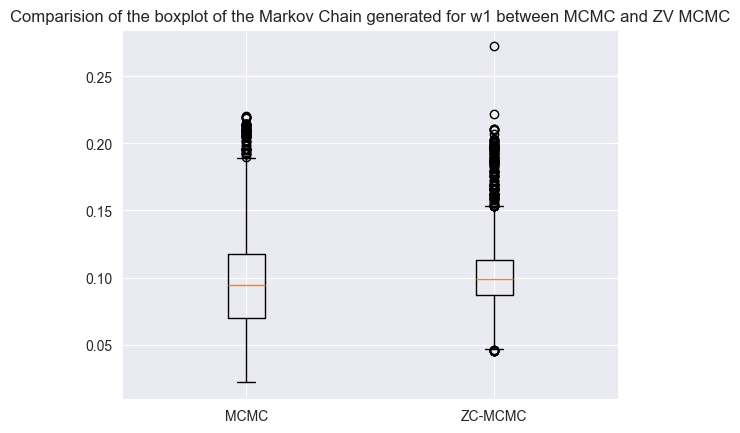

In [ ]:
boxplot_comparison(w_tilde[0][:, 0], [sub_array[0] for sub_array in w1_results(w_tilde)[4]], 'w1')


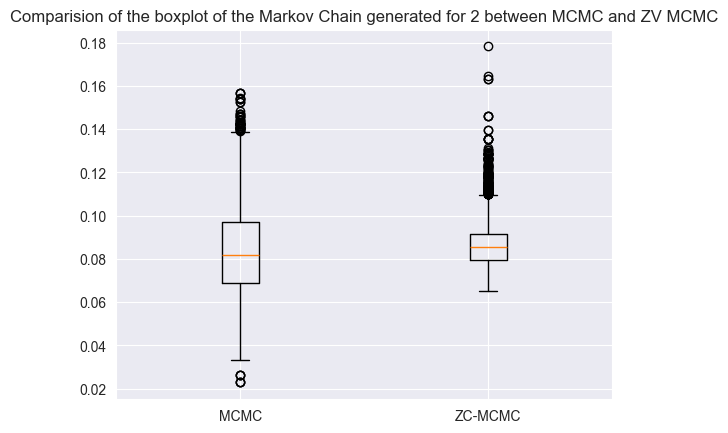

In [ ]:
boxplot_comparison(w_tilde[0][:, 1], [sub_array[1] for sub_array in w2_results(w_tilde)[4]], '2')

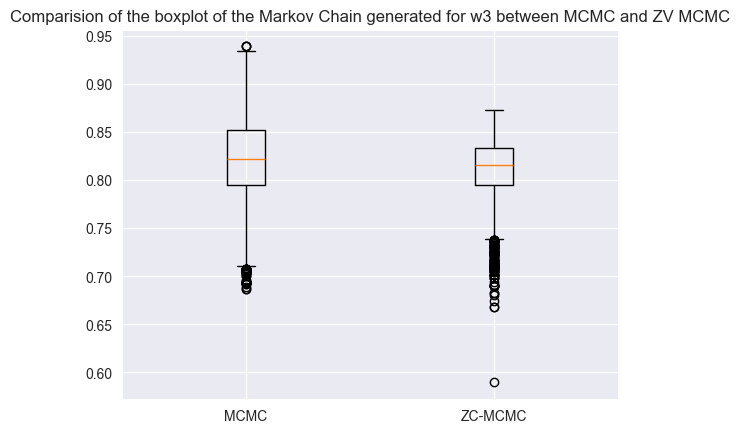

In [ ]:
boxplot_comparison(w_tilde[0][:, 2], [sub_array[2] for sub_array in w3_results(w_tilde)[4]], 'w3')


In [ ]:
def mean_metropolis_algorithm(iterations_mean_algo):
    liste_w1_CV = []
    liste_w2_CV = []
    liste_w3_CV = []
    
    liste_w1_noCV = []
    liste_w2_noCV = []
    liste_w3_noCV = []
    for i in range(iterations_mean_algo):
        # Run Metropolis sampler
        samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)
    
        # Extract parameter chains
        w_samples = extract_parameter_chains(samples)
        
        # Compute control variates
        z_samples = compute_control_variates(w_samples)
        #z_samples = control_variates(returns, sigma_omega, w_samples)
        
        # Linear regression
        coefficients = fit_linear_regression(w_samples[burn_in:], z_samples[burn_in:])
        
        # Post-processing
        w, transw = post_process_samples(w_samples, z_samples, burn_in, coefficients)

        w1 = [sub_array[0] for sub_array in w]
        w2 = [sub_array[1] for sub_array in w]
        w3 = [sub_array[2] for sub_array in w]

        transw1 = [sub_array[0] for sub_array in transw]
        transw2 = [sub_array[1] for sub_array in transw]
        transw3 = [sub_array[2] for sub_array in transw]

        w1_tilde = sum_list(w1[burn_in:], transw1)
        w2_tilde = sum_list(w2[burn_in:], transw2)
        w3_tilde = sum_list(w3[burn_in:], transw3)

        liste_w1_noCV.append(np.mean(w1[burn_in:]))
        liste_w2_noCV.append(np.mean(w2[burn_in:]))
        liste_w3_noCV.append(np.mean(w3[burn_in:]))

        liste_w1_CV.append(np.mean(w1_tilde))
        liste_w2_CV.append(np.mean(w2_tilde))
        liste_w3_CV.append(np.mean(w3_tilde))
        
    return [liste_w1_CV,liste_w2_CV,liste_w3_CV], [liste_w1_noCV, liste_w2_noCV, liste_w3_noCV]

In [ ]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]
true_omega = [0.1, 0.1, 0.8]  # These are the true parameters we want to estimate
sigma_omega = [9,9,9]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = true_omega, T = 1000)[0]

iterations = 5000
burn_in = 1000
sigma_proposal = 0.01

# We apply 5 times the metropolis algorithm defined in Q2
mean_metrop_algo = mean_metropolis_algorithm(5) #it took more 30 min for 50 cycles

In [ ]:
def biais_estimateur(U):
    return statistics.mean(U[0]) - true_omega[0], statistics.mean(U[1]) - true_omega[1], statistics.mean(U[2]) - true_omega[2]

def mean_estimateur(U):
    return statistics.mean(U[0]), statistics.mean(U[1]), statistics.mean(U[2])

def variance_estimateur(U):
    return statistics.variance(U[0]), statistics.variance(U[1]), statistics.variance(U[2])


In [ ]:
print(f"The bias of the estimator without Control Variates is: {biais_estimateur(mean_metrop_algo[1])}")
print(f"The bias of the estimator with Control Variates is: {biais_estimateur(mean_metrop_algo[0])}")

print(f"The mean of the estimator without Control Variates is: {mean_estimateur(mean_metrop_algo[1])}")
print(f"The mean of the estimator with Control Variates is: {mean_estimateur(mean_metrop_algo[0])}")

print(f"The variance of the estimator without Control Variates is: {variance_estimateur(mean_metrop_algo[1])}")
print(f"The variance of the estimator with Control Variates is: {variance_estimateur(mean_metrop_algo[0])}")


The bias of the estimator without Control Variates is: (0.013157415431029496, -0.008580408926366648, -0.002933190128586949)
The bias of the estimator with Control Variates is: (0.008004142057144198, -0.009932271501765455, 0.003428313237281433)
The mean of the estimator without Control Variates is: (0.1131574154310295, 0.09141959107363336, 0.7970668098714131)
The mean of the estimator with Control Variates is: (0.1080041420571442, 0.09006772849823455, 0.8034283132372815)
The variance of the estimator without Control Variates is: (0.00011459969974500486, 3.0812093318422335e-05, 0.0002171298444808661)
The variance of the estimator with Control Variates is: (4.475421564529897e-05, 8.871232812304154e-06, 8.252077698462909e-05)


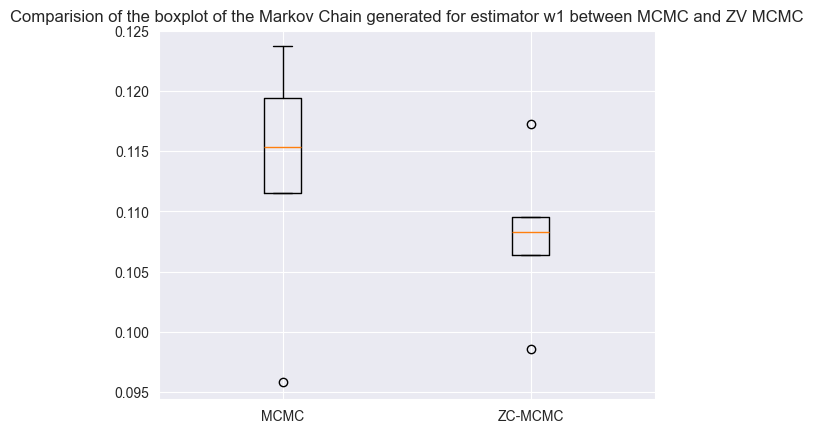

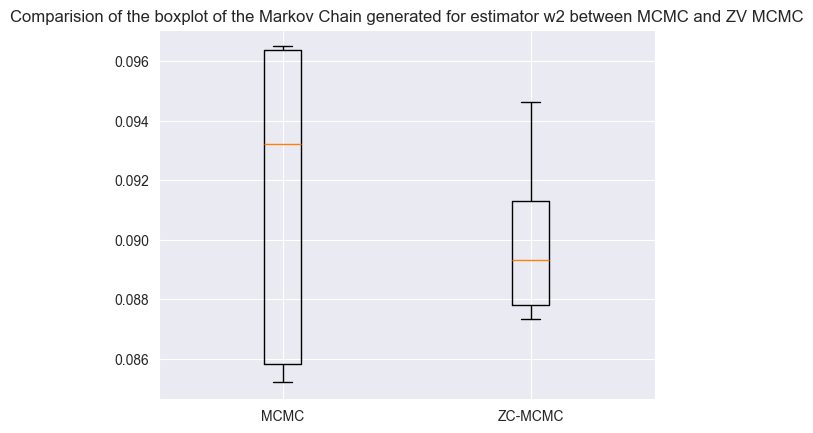

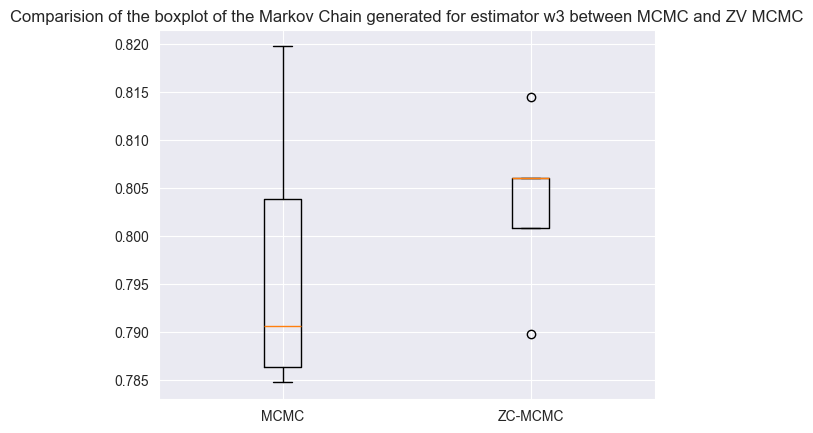

In [ ]:
boxplot_comparison(mean_metrop_algo[1][0], mean_metrop_algo[0][0], 'estimator w1')
boxplot_comparison(mean_metrop_algo[1][1], mean_metrop_algo[0][1], 'estimator w2')
boxplot_comparison(mean_metrop_algo[1][2], mean_metrop_algo[0][2], 'estimator w3')

# Q4

In [ ]:
import random
# Subsampling : we use the 15*np.sqrt(N) number of subsamples
#as detailed in the 2nd paper with the LSLASSO(X) Method. 

iterations = 5000
N = np.sqrt(iterations)*15 
length_subsample = int(N)

indices = random.sample(range(1, iterations), length_subsample)
indices = sorted(indices)

def extract_parameter_subsampled_chains(liste):
    w1 = [elem[0] if isinstance(elem, np.ndarray) else elem[0] for elem in liste[1]]
    w2 = [elem[1] if isinstance(elem, np.ndarray) else elem[1] for elem in liste[1]]
    w3 = [elem[2] if isinstance(elem, np.ndarray) else elem[2] for elem in liste[1]]
    w1_subsampled = [w1[i] for i in indices]
    w2_subsampled = [w2[i] for i in indices]
    w3_subsampled = [w3[i] for i in indices]
    return np.column_stack((w1_subsampled, w2_subsampled, w3_subsampled))

NameError: name 'np' is not defined

In [ ]:
def w_tilde_subsampled(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in):
    # Run Metropolis sampler
    samples = metropolis_hasting_algorithm(iterations, returns, sigma_proposal, initial_omega, sigma_omega)
    
    # Extract parameter chains
    w_subsamples = extract_parameter_subsampled_chains(samples)
    
    # Compute control variates
    z_samples = compute_control_variates(w_subsamples)
    #z_samples = control_variates(returns, sigma_omega, w_samples)
    
    # Linear regression
    coefficients = fit_linear_regression(w_subsamples[burn_in:], z_samples[burn_in:])
    
    # Post-processing
    w_subsamples_after_burn_in, transformed_samples = post_process_samples(w_subsamples, z_samples, burn_in, coefficients)

    # Print coefficients
    print("Coefficients of a from the regression of w on the control variates: ", coefficients)

    return w_subsamples_after_burn_in, transformed_samples


In [ ]:
# Initialization of our Markov Chain 
initial_omega = [0.3,0.3,0.3]
true_omega = [0.1, 0.1, 0.8]  # These are the true parameters we want to estimate
sigma_omega = [9,9,9]

# We simulate our data following a Garch(1,1) with parameters w1, w2 and w3 fixed to check if we have a close expeted value
returns = simulate_garch(omega = true_omega, T = 1000)[0]

iterations = 5000
burn_in = 1000

sigma_proposal = 0.01

w_tilde=w_tilde_subsampled(iterations, returns, sigma_proposal, initial_omega, sigma_omega, burn_in)

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by LinearRegression.

In [ ]:
def w1_results(w):
    w1 = w_tilde[0][0:]
    transw1 = w_tilde[1][0:]
    w1_tilde = [x + y for x, y in zip(w1, transw1)]
    return np.mean(w1), np.mean(w1_tilde), np.var(w1), np.var(w1_tilde), w1_tilde

print("Expected value of w1 =", w1_results(w_tilde)[0])
print("Expected value of w1_tilde =", w1_results(w_tilde)[1])
print("Variance of w1 =", w1_results(w_tilde)[2])
print("Variance of w1_tilde =", w1_results(w_tilde)[3]) 

In [ ]:
def w2_results(w):
    w2 = w[0][1:]
    transw2 = w[1][1:]
    w2_tilde = [x + y for x, y in zip(w2, transw2)]
    return np.mean(w2), np.mean(w2_tilde), np.var(w2), np.var(w2_tilde), w2_tilde

mean_w2, mean_w2_tilde, var_w2, var_w2_tilde, _ = w2_results(w_tilde)

# Print results
print(f"Expected value of w2 = {mean_w2}")
print(f"Expected value of w2_tilde = {mean_w2_tilde}")
print(f"Variance of w2 = {var_w2}")
print(f"Variance of w2_tilde = {var_w2_tilde}")

In [ ]:
def w3_results(w):
    w3 = w[0][2:]
    transw3 = w[1][2:]
    w3_tilde = [x + y for x, y in zip(w3, transw3)]
    return np.mean(w3), np.mean(w3_tilde), np.var(w3), np.var(w3_tilde), w3_tilde

mean_w3, mean_w3_tilde, var_w3, var_w3_tilde, _ = w3_results(w_tilde)

# Print results
print(f"Expected value of w3 = {mean_w3}")
print(f"Expected value of w3_tilde = {mean_w3_tilde}")
print(f"Variance of w3 = {var_w3}")
print(f"Variance of w3_tilde = {var_w3_tilde}")

In [ ]:
boxplot_comparison(w_tilde[0][:, 0], [sub_array[0] for sub_array in w1_results(w_tilde)[4]], 'w1')


In [ ]:
boxplot_comparison(w_tilde[0][:, 1], [sub_array[1] for sub_array in w2_results(w_tilde)[4]], '2')

In [ ]:
boxplot_comparison(w_tilde[0][:, 2], [sub_array[2] for sub_array in w3_results(w_tilde)[4]], 'w3')
